In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

2023-12-14 22:29:54.726057: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-14 22:29:54.753535: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 22:29:54.753565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 22:29:54.754249: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 22:29:54.758914: I tensorflow/core/platform/cpu_feature_guar

In [2]:
X_data = np.load("../data/data_64_30.npy")
X_data = np.transpose(X_data, (0, 2, 1))
print(X_data.shape)

(13100, 30, 64)


In [3]:
data = pd.read_csv(
    "../data/LJSpeech-1.1/metadata.csv",
    sep="|",
    header=None,
    names=["ID", "Text1", "Text2"],
)
texts = data["Text1"].to_list()
ID = data["ID"].to_list()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
num_classes = len(tokenizer.word_index) + 1  # Add 1 for the padding token
sequences = tokenizer.texts_to_sequences(texts)
Y_data = pad_sequences(sequences, padding="post", maxlen=30)
print(Y_data.shape)

(13100, 30)


In [4]:
class ConvolutionalLayer(tf.keras.layers.Layer):  # Change the base class to tf.keras.layers.Layer
    def __init__(self, input_shape, filters=32, kernel_size=3, **kwargs):
        super(ConvolutionalLayer, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size

        # Extract the number of filters from the input shape
        if isinstance(input_shape, tuple):
            self.filters = input_shape[-1]

        self.conv1 = layers.Conv1D(filters=self.filters, kernel_size=self.kernel_size, padding="same")
        self.batch_norm1 = layers.BatchNormalization()
        self.relu1 = layers.ReLU()

        self.conv2 = layers.Conv1D(filters=self.filters, kernel_size=self.kernel_size, padding="same")
        self.batch_norm2 = layers.BatchNormalization()
        self.relu2 = layers.ReLU()

    def call(self, inputs, training=None, mask=None):
        conv1_out = self.relu1(self.batch_norm1(self.conv1(inputs), training=training))
        conv2_out = self.relu2(self.batch_norm2(self.conv2(conv1_out), training=training))
        # print("CNN output shape is ",conv2_out.shape)
        return conv2_out


In [5]:

class CNN(tf.keras.Model):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_layer = ConvolutionalLayer(input_shape=(30, 64))  # Adjust input shape

    def call(self, inputs, training=None):
        cnn_output = self.cnn_layer(inputs, training=training)  # Explicitly call the 'call' method
        return cnn_output

In [6]:
def scaled_dot_product(q, k, v, mask):
    d_k = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_qk = tf.matmul(q, k, transpose_b=True) / tf.math.sqrt(d_k)

    if mask is not None:
        scaled_qk += mask

    attention_weights = tf.nn.softmax(scaled_qk)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [7]:
class PositionwiseFeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = tf.keras.layers.Dense(hidden)
        self.linear2 = tf.keras.layers.Dense(d_model)
        self.relu = tf.keras.layers.ReLU()
        self.dropout = tf.keras.layers.Dropout(rate=drop_prob)

    
    def call(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [8]:
class PostionalEmbedding(tf.keras.Model):
    def __init__(self,vocab_size=num_classes,embedding_dim=64):
        super(PostionalEmbedding,self).__init__()
        self.embedding = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=30)
    
    def call(self,input,training=None):
        if input.shape == (100,30,64):
            return input
        else:
            output = self.embedding(input)
            return output

In [9]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = tf.keras.layers.Dense(3 * d_model, use_bias=False)
        self.linear_layer = tf.keras.layers.Dense(d_model, activation='relu')

    def split_heads(self, x, batch_size):
        if len(x.shape) == 2:
            x = tf.expand_dims(tf.expand_dims(x, axis=0), axis=1)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, x, mask):
        batch_size, _, _ = x.shape

        qkv = self.qkv_layer(x)
        q, k, v = tf.split(qkv, 3, axis=-1)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        values, attention = scaled_dot_product(q, k, v, mask)

        values = tf.transpose(values, perm=[0, 2, 1, 3])
        values = tf.reshape(values, (batch_size, -1, self.num_heads * self.head_dim))
        out = self.linear_layer(values)
        return out


In [10]:
class MulticrossHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MulticrossHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = tf.keras.layers.Dense(3 * d_model, use_bias=False)
        self.linear_layer = tf.keras.layers.Dense(d_model, activation='relu')

    def split_heads(self, x, batch_size):
        if len(x.shape) == 2:
            x = tf.expand_dims(tf.expand_dims(x, axis=0), axis=1)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, x,encoder_output,  mask):
        batch_size, _, _ = x.shape

        qkv = self.qkv_layer(x)
        q, k, _ = tf.split(qkv, 3, axis=-1)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)

        qkv = self.qkv_layer(encoder_output)
        _, _, v = tf.split(qkv, 3, axis=-1)
        v = self.split_heads(v, batch_size)
        values, attention = scaled_dot_product(q, k, v, mask)

        values = tf.transpose(values, perm=[0, 2, 1, 3])
        values = tf.reshape(values, (batch_size, -1, self.num_heads * self.head_dim))
        out = self.linear_layer(values)
        return out


In [11]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, hidden, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()
        self.cnn_layer = CNN()
        self.multihead_attention = MultiHeadAttention(d_model, num_heads)
        self.feedforward = PositionwiseFeedForward(d_model, hidden, drop_prob=dropout_rate)
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

    def call(self, x, training=None, mask=None):
        x = self.cnn_layer(x)
        x_att = self.multihead_attention(x, mask)
        x = x + x_att
        x = self.dropout(x)
        x = self.feedforward(x)
        return x

In [12]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, hidden, dropout_rate=0.1):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.hidden = hidden
        self.dropout_rate = dropout_rate

        # Define layers
        self.encoder_layers = [EncoderLayer(d_model, num_heads, hidden, dropout_rate) for _ in range(num_layers)]

    def call(self, x, training=None, mask=None):
        for i in range(self.num_layers):
            x = self.encoder_layers[i](x, training=training, mask=mask)
        return x

In [13]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, vocab_size, hidden, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()
        self.embedding = PostionalEmbedding(vocab_size=vocab_size, embedding_dim=64)
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.cross_attention = MulticrossHeadAttention(d_model, num_heads)
        self.feedforward = PositionwiseFeedForward(d_model, hidden, drop_prob=dropout_rate)

    def call(self, inputs, encoder_output, training=None, mask=None):
        # Self-attention on the decoder side
        x = self.embedding(inputs)
        x_att_self = self.self_attention(x, mask)
        x = x + x_att_self
        x = self.dropout(x)

        # Cross-attention with the encoder output
        x_att_cross = self.cross_attention(x, encoder_output, mask)
        x = x + x_att_cross
        x = self.dropout(x)

        # Feedforward layer
        x = self.feedforward(x)
        return x


In [14]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, num_layers, d_model, num_heads, hidden, dropout_rate=0.1):
        super(Decoder, self).__init__()
        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.hidden = hidden
        self.dropout_rate = dropout_rate
        self.flatten = layers.Flatten()
        # self.output_layer = layers.Dense(Y_data.shape[-1], activation='softmax')
        self.output_layer = layers.Dense(30, activation = "relu")
        # Modify the output layer in the Decoder class
        # self.output_layer = layers.Dense(num_classes, activation='softmax')



        # Define layers
        self.decoder_layers = [DecoderLayer(d_model, num_heads, vocab_size, hidden, dropout_rate) for _ in range(num_layers)]

    def call(self, x,encoder_output, training=None, mask=None):
        for i in range(self.num_layers):
            x = self.decoder_layers[i](x,encoder_output, training=training, mask=mask)
        x = self.flatten(x)
        x = self.output_layer(x)
        return x


In [15]:
class Transformer(tf.keras.Model):
    def __init__(self ,d_model,num_heads,hidden,num_layers,voacb_size,dropout_rate=0.1):
        super(Transformer,self).__init__()
        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.hidden = hidden
        self.dropout_rate = dropout_rate
        self.encoder = Encoder(d_model=d_model,num_heads=num_heads,hidden=hidden,num_layers=num_layers)
        self.decoder = Decoder(d_model=d_model,num_heads=num_heads,num_layers=num_layers,hidden=hidden,dropout_rate=dropout_rate,vocab_size=voacb_size)

    def call(self,x,training=None,mask=None):
        encoder_output = self.encoder(x[:,:,:64],training,mask)
        decoder_output = self.decoder(x[:,:,64],encoder_output,training,mask)
        return decoder_output


        

In [16]:
d_model = 64
num_heads = 8
hidden = 2048
num_layer = 5                                                                                                                                                                                                                                                                  
vocab_size = num_classes
dropout_rate =0.1
transformer = Transformer(d_model=d_model,num_heads=num_heads,hidden=hidden,num_layers=num_layer,voacb_size=vocab_size,dropout_rate=dropout_rate)

2023-12-14 22:29:56.575034: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-14 22:29:56.602856: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-14 22:29:56.603046: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [17]:
# Instantiate an optimizer to train the model.
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
# Instantiate a loss function.
# loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn = keras.losses.MeanSquaredError()
loss_fn = keras.losses.MeanAbsoluteError()

# Prepare the metrics.
train_acc_metric = keras.metrics.MeanSquaredError()
val_acc_metric = keras.metrics.MeanSquaredError()

In [18]:
Y_data_copy = Y_data
Y_data_copy = Y_data_copy[:,:,np.newaxis]
result = np.concatenate((X_data, Y_data_copy), axis=-1)
print(result.shape)

(13100, 30, 65)


In [19]:
transformer.build(input_shape=(100,30,65))

In [20]:
epochs = 20
batch_size = 100
training_loss_values = []
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch}")

    # Initialize variables to accumulate loss
    total_loss = 0
    num_batches = 0

    # Iterate over the batches of the dataset.
    for step in range(0, len(result), batch_size):
        x_batch_train = result[step:step+batch_size, :, :]
        y_batch_train = result[step:step+batch_size, :, 64]

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            # Run the forward pass of the layer.
            logits = transformer(x_batch_train, training=True)  # Logits for this minibatch
            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, transformer.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, transformer.trainable_weights))

        # Accumulate the loss
        total_loss += loss_value
        num_batches += 1

        # Log every 100 batches.
        if step % 100 == 0:
            print(
                f"Training loss at step {step}: {float(loss_value):.4f}"
            )
            print(f"Seen so far: {step} samples")

    # Calculate and print the average loss for the epoch
    avg_loss = total_loss / num_batches
    training_loss_values.append(avg_loss)
    print(f"Average training loss for epoch {epoch + 1}: {float(avg_loss):.4f}")

    print(f"\nEpoch {epoch + 1} ended")



Start of epoch 0


2023-12-14 22:29:58.057133: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-14 22:29:58.130967: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-14 22:29:58.316823: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-14 22:29:59.883222: I external/local_xla/xla/service/service.cc:168] XLA service 0x1cfef9b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-14 22:29:59.883253: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-12-14 22:29:59.886866: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702573199.961398   21795 device_compiler.h:18

Training loss at step 0: 735.1713
Seen so far: 0 samples
Training loss at step 100: 651.9716
Seen so far: 100 samples
Training loss at step 200: 463.0652
Seen so far: 200 samples
Training loss at step 300: 640.8448
Seen so far: 300 samples
Training loss at step 400: 623.5383
Seen so far: 400 samples
Training loss at step 500: 513.1354
Seen so far: 500 samples
Training loss at step 600: 595.5078
Seen so far: 600 samples
Training loss at step 700: 628.4067
Seen so far: 700 samples
Training loss at step 800: 588.5087
Seen so far: 800 samples
Training loss at step 900: 652.2629
Seen so far: 900 samples
Training loss at step 1000: 654.3896
Seen so far: 1000 samples
Training loss at step 1100: 756.7444
Seen so far: 1100 samples
Training loss at step 1200: 533.5228
Seen so far: 1200 samples
Training loss at step 1300: 537.4056
Seen so far: 1300 samples
Training loss at step 1400: 615.9465
Seen so far: 1400 samples
Training loss at step 1500: 607.6205
Seen so far: 1500 samples
Training loss at

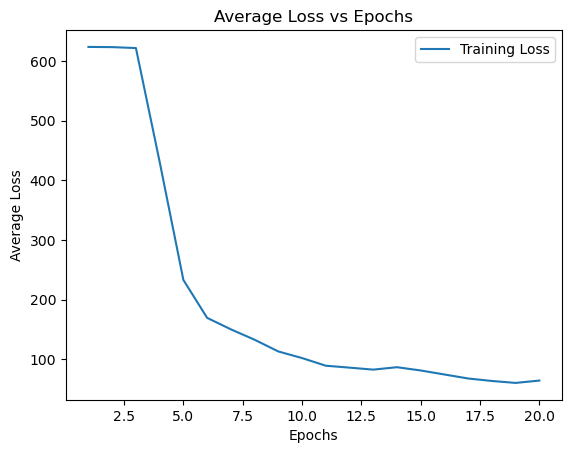

In [21]:
# Plot the training loss
plt.plot(range(1, epochs + 1), training_loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Average Loss vs Epochs')
plt.legend()
plt.show()

In [22]:
predictions = transformer.predict(result[:100, :, :], batch_size=batch_size)

# 'predictions' will contain the model's predictions for the test_data
print("Shape of Predictions:", predictions.shape)

1/1 [==============================] - 1s 757ms/step
Shape of Predictions: (100, 30)


In [25]:
print(predictions[1])

[   0.       185.88185 4379.4717   650.7443     0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.     ]


In [26]:
print(result[1,:,64])

[   5.  173. 4409.  656.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.]
